In [1]:
import matplotlib
import boto3
from botocore.exceptions import ClientError
from netCDF4 import Dataset
import datetime as dt
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import xmltodict
import yaml
import os
import subprocess
from datetime import date
from datetime import datetime
import logging
logger = logging.getLogger()
import os
import netCDF4
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

In [2]:
logger.setLevel(level=logging.INFO)

# Open configuration file and read paramters

In [115]:
with open(r'config.yaml') as file:
    configuration =  yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
for config in configuration['configurations']:
    print(config)
    username = config['username']
    password = config['password']
    url = config['url']
    aoi = config['aoi']
    awss3bucket = config['awss3bucket']
    awskeyid = config['awskeyid']
    awskeypass = config['awskeypass']

# Functions

In [5]:
def filter(sensors):

    for sensordict in sensors:
        
        filter_string = ''
        count = 0
        
        for sensor in sensordict.keys():
            filter_string = filter_string+'(sensor=%27'+sensor+'%27%20AND%20(product=%27'
            product_count = 0
            for product in sensordict[sensor]:
                filter_string = filter_string+product+'%27'
                if product_count < (len(sensordict[sensor])-1):
                    filter_string = filter_string+'%20OR%20product=%27'
                else:
                    filter_string = filter_string+'))' 
                product_count = product_count + 1
            if count < (len(sensordict.keys())-1):        
                filter_string = filter_string+'%20OR%20'
            count = count+1

    return(filter_string)

In [6]:
def get_polygon_from_gml(gml_dict):
    listoftuples = []
    for i in list(gml_dict.split(" ")):
        pair = (float(i.split(',')[1]), float(i.split(',')[0]))
        listoftuples.append(pair)
    return(listoftuples)

In [7]:
def load_hotspots(filter_string, time_period, bbox, max_features, min_confidence, to_date):
    y_max = bbox[0]
    x_min = bbox[1]
    y_min = bbox[2]
    x_max = bbox[3]
    if to_date is None:
        
        to_date = dt.datetime.now()
    
    
    from_date = (to_date - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
    
    # trim datetime to enable WFS 
    to_date = to_date.strftime('%Y-%m-%d')
    logger.info(str(from_date)+' '+str(to_date))
    
    # TODO - sort out paging - looks like there is a limit to WFS requests number returned per query
    logger.info(f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({filter_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_max}%20{x_min},%20{y_max}%20{x_max},%20{y_min}%20{x_max},%20{y_min}%20{x_min},%20{y_max}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A")
    url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({filter_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_max}%20{x_min},%20{y_max}%20{x_max},%20{y_min}%20{x_max},%20{y_min}%20{x_min},%20{y_max}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
    
    hotspots_gdf = gpd.read_file(url)
    #logger.info(str(hotspots_gdf['stop_dt']))
    
    # TODO - improved None value handling  -currently just look at first and apply that to all
    if hotspots_gdf['confidence'][0] == None:
        logger.info('Skipping confidence filter as confidence not populated')
    else:

        # Filter by confidence
        hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

    # Fix datetime
    if hotspots_gdf['start_dt'][0] == None:
        logger.info('Start date field is not populated')
        hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['datetime'])
    else:
        hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

    # Extract required columns
    hotspots_gdf = hotspots_gdf.loc[:, [
            'datetime', 'latitude', 'longitude', 'confidence', 'geometry', 'product', 'satellite', 'sensor', 'power'
            ]]
    hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
    logger.info('Hotspots loaded successfully '+str(hotspots_gdf.geometry.total_bounds))

    return(hotspots_gdf)

In [8]:
def solar_day(utc, latitude):
    SECONDS_PER_DEGREE = 240
    offset_seconds = int(latitude * SECONDS_PER_DEGREE)
    offset = np.timedelta64(offset_seconds, 's')
    return (np.datetime64(utc) + offset).astype(datetime)

# Assess inventory against AWS bucket listing

In [9]:
# Get bucket listing of image granules and hotspot files

s3 = boto3.resource('s3', aws_access_key_id=awskeyid,
                    aws_secret_access_key=awskeypass)

s3folderlist = []
s3geojsonlist = []
s3bucket = s3.Bucket('s3vtaustralia')

for bucket_object in s3bucket.objects.all():
    s3bucketobject = str(bucket_object.key).split("/")[2]
    if '.SEN3' in s3bucketobject:
        s3folderlist.append(s3bucketobject)
    if '.FRP.geojson' in s3bucketobject:
        s3geojsonlist.append(bucket_object.key)

print(len(s3geojsonlist), "S3 Hotspot files From ESA available in AWS S3") 

3452 S3 Hotspot files From ESA available in AWS S3


In [10]:
print(len(set(s3folderlist)), "S3 Granules From ESA available in AWS S3") 

7644 S3 Granules From ESA available in AWS S3


# Retrieve the file list inventory used to gather the S3 files

In [11]:
# Get File List from server
# Run this if no local inventory exists
if not os.path.exists('s3vt_inventory.json'):
    startrecord = 0

    responselist = [] 

    # Determine number of records to retrieve
    get_file_list(username, password, aoi, str(startrecord))
    with open('filelist.txt') as results:
        for i in results: 
            response = json.loads(i)
            responselist.append(response)

    upperlimit = int(response['feed']['opensearch:totalResults'])
    upperlimit = 200
    # Get the full list of records

    while startrecord <= upperlimit:
        startrecord = startrecord+100

        get_file_list(username, password, aoi, str(startrecord)) 
        with open('filelist.txt') as results:
            for i in results: responselist.append(json.loads(i))

            # Dump the results to an inventory file
            with open('s3vt_inventory.json', 'w') as f:
                json.dump(responselist, f)

# From the inventory - generate a vector fooprint

In [12]:
# Read inventory to geopandas - write to geojson       
        
with open('s3vt_inventory.json') as inventory:
    frames = []
    for p in inventory:
        pages = json.loads(p)
                
        for page in pages:
            for page in pages:
                try:
                    
                    for entry in page['feed']['entry']:

                        df = pd.DataFrame.from_dict(entry, orient='index')

                        polygon = get_polygon_from_gml(xmltodict.parse(entry['str'][2]['content'])['gml:Polygon']['gml:outerBoundaryIs']['gml:LinearRing']['gml:coordinates'])

                        df = df.transpose()
                        df['Coordinates'] = Polygon(polygon)
                        for d in entry['str']:
                            if d['name'] ==  'orbitdirection':
                                df['orbitdirection'] = d['content']
                            if d['name'] ==  'platformidentifier':
                                df['platformidentifier'] = d['content'] 
                            if d['name'] ==  'filename':
                                df['filename'] = d['content']
                            if d['name'] ==  'instrumentshortname':
                                df['instrumentshortname'] = d['content']
                            if d['name'] ==  'passnumber':
                                df['passnumber'] = d['content']        
                        s3vtdf = gpd.GeoDataFrame(df, geometry='Coordinates')

                        frames.append(s3vtdf)
                                
                except KeyError:
                        logger.info("KeyError exception for get_polygon_from_gml()")
                        
s3vtgpd = pd.concat(frames)

# Not sure why we need to index but do it anyway
s3vtgpd = s3vtgpd.reset_index(drop=True)
s3vtgpd['date'] = pd.to_datetime(s3vtgpd.summary.str.split(",", expand= True)[0].str.split(' ', expand=True)[1])
# Some fields are lists and geojson translation doesn't like it

s3vtgpd = s3vtgpd.drop(['link', 'int', 'str', 'summary'], axis=1)
s3vtgpd.to_file('s3vt_geometry.geojson', driver='GeoJSON')

# Set up for checking inventory against files on AWS

In [13]:
dataframelength = len(s3vtgpd)
# Add field to enable monitoring
s3vtgpd['hotspot'] = 0
s3vtgpd['download'] = 0
s3vtgpd['s3bucket'] = 0

s3vthostpotsgpdlist = []

# Run inventory check

In [14]:
# Check if folder already downloaded and flag in gpd
for i in range(dataframelength):
    if s3vtgpd.loc[i]['title']+'.SEN3' in set(s3folderlist):
        s3vtgpd.at[i, 'download'] = 1
    if s3vtgpd.loc[i]['title']+'.FRP.geojson' in set(s3folderlist):
        s3vtgpd.at[i, 'hotspot'] = 1
        s3vthostpotsgpdlist.append(s3hotspotsgpd)

# Sync GeoJSON to local machine

In [17]:
# Copy all S3 geojson files locally and load to GPD
subprocess.call(['aws', 's3', 'sync', 's3://s3vtaustralia/', '.', '--exclude', '''*''', '--include', '''*.geojson''', '--dryrun'])

#for i in s3geojsonlist:
#    print(i)
#    subprocess.call(['aws', 's3', 'sync', 's3://s3vtaustralia/'+i, i, '--dryrun'])

0

# Filter hotspots based on limitations stated by UCL

In [18]:
frames = []
for i in s3geojsonlist:
    df1 = gpd.read_file(i)
    if 'S3A' in i:
        df1['satellite'] = 'S3A'
    else:
        df1['satellite'] = 'S3B'
    df1['sensor'] = 'SLSTR'
    df2 = df1.query("FRP_MWIR>0")
    if len(df2) > 0:
        frames.append(df2)
        
s3vthotspots = pd.concat(frames)
#for i in s3geojsonlist:
#    s3vtdf = gpd.GeoDataFrame(df, geometry='Coordinates')

# Convert netcdf CF time to something pandas understands

In [19]:
s3vthotspots['date'] = pd.to_datetime(netCDF4.num2date(s3vthotspots.time, units='microseconds since 2000-01-01T00:00:00Z', only_use_cftime_datetimes=False, only_use_python_datetimes=True))

# Add solar day column to enable group by function

In [20]:
s3vthotspots['solar_day'] = s3vthotspots.apply(lambda row: solar_day(row.date, row.latitude), axis = 1)

# Write S3 Hotspots to GeoJSON

In [21]:
s3vthotspots.to_file('s3vt_hotspots.geojson', driver='GeoJSON')

In [22]:
bounds = list(s3vthotspots.geometry.total_bounds)
bbox = [bounds[3], bounds[0], bounds[1], bounds[2]]
bbox

[12.234104969111854, -179.98885754557182, -46.4811018826465, 179.9494145456714]

In [23]:
# Get time bounds for DEA Hotspots query
# TODO - AHI hotspots

maxdate = s3vthotspots.date.max().to_datetime64()
mindate = s3vthotspots.date.min().to_datetime64()
to_date = dt.datetime.strptime(str(s3vthotspots.date.max().to_datetime64()), '%Y-%m-%dT%H:%M:%S.%f000') # '2018-01-01T00:00:00.000Z'

In [24]:
time_period = int(str(np.timedelta64(maxdate - mindate, 'D')).split(' ')[0])

In [117]:
for config in configuration['configurations']:
    
    hotspots_gdf = load_hotspots(filter(config['sensors']),
                                         time_period,
                                         bbox,
                                         config['max_features'], 
                                         config['min_confidence'],
                                         to_date)
hotspots_gdf['solar_day'] = hotspots_gdf.apply(lambda row: solar_day(row.datetime, row.latitude), axis = 1) 

In [118]:
try:
    os.remove('DEAHotspots_hotspots.geojson')
except:
    hotspots_gdf.to_file('DEAHotspots_hotspots.geojson', driver='GeoJSON')

In [27]:
hotspots_gdf.datetime.max()

Timestamp('2020-04-16 17:12:01')

In [28]:
s3vthotspots.date.max()

Timestamp('2020-04-17 03:26:48.243559')

In [ ]:
s3vthotspots.plot()

In [ ]:
hotspots_gdf.plot()

# Load Hotspots to GeoPandas

In [ ]:
hotspots_gdf = gpd.read_file('DEAHotspots_hotspots.geojson')

In [ ]:
s3vthotspots = gpd.read_file('s3vt_hotspots.geojson')

In [52]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True).add_prefix('2_'),
         pd.Series(dist, name='dist')], axis=1)
    return gdf



In [30]:
set(hotspots_gdf.satellite)

{'AQUA', 'NOAA 19', 'NOAA 20', 'SUOMI NPP', 'TERRA'}

# Set products for comparison

In [119]:
products = [{'product': 'SRSS', 'sensor': 'MODIS', 'satellite': 'TERRA'},
 {'product': 'MOD14', 'sensor': 'MODIS', 'satellite': 'TERRA'},
 {'product': 'SRSS', 'sensor': 'MODIS', 'satellite': 'AQUA'},
 {'product': 'MOD14', 'sensor': 'MODIS', 'satellite': 'AQUA'},                        
 {'product': 'SRSS', 'sensor': 'AVHRR', 'satellite': 'NOAA 19'},
 {'product': 'GA', 'sensor': 'AVHRR', 'satellite': 'NOAA 19'},
 {'product': 'SRSS', 'sensor': 'VIIRS', 'satellite': 'NOAA 20'},
 {'product': 'AFMOD', 'sensor': 'VIIRS', 'satellite': 'NOAA 20'},
 {'product': 'EDR', 'sensor': 'VIIRS', 'satellite': 'NOAA 20'},
 {'product': 'SRSS', 'sensor': 'VIIRS', 'satellite': 'SUOMI NPP'},
 {'product': 'AFMOD', 'sensor': 'VIIRS', 'satellite': 'SUOMI NPP'},
 {'product': 'EDR', 'sensor': 'VIIRS', 'satellite': 'SUOMI NPP'}] 

# Index by solar time to enable groupby

In [120]:
hotspots_gdf.set_index(pd.DatetimeIndex(hotspots_gdf.solar_day.values))


,datetime,latitude,longitude,confidence,geometry,product,satellite,sensor,power,solar_day
2020-02-02 21:28:45,2020-02-02 23:51:16,-35.6330,148.7960,66,POINT (148.79600 -35.63300),MOD14,TERRA,MODIS,22.1,2020-02-02 21:28:45
2020-02-02 21:27:40,2020-02-02 23:51:16,-35.9010,149.0630,84,POINT (149.06300 -35.90100),MOD14,TERRA,MODIS,45.9,2020-02-02 21:27:40
2020-02-02 21:28:10,2020-02-02 23:51:16,-35.7750,148.9160,99,POINT (148.91600 -35.77500),MOD14,TERRA,MODIS,84.0,2020-02-02 21:28:10
2020-02-02 21:27:42,2020-02-02 23:51:16,-35.8920,149.0660,64,POINT (149.06600 -35.89200),MOD14,TERRA,MODIS,24.8,2020-02-02 21:27:42
2020-02-02 21:28:51,2020-02-02 23:51:16,-35.6050,148.8030,83,POINT (148.80300 -35.60500),MOD14,TERRA,MODIS,32.8,2020-02-02 21:28:51
...,...,...,...,...,...,...,...,...,...,...
2020-04-16 14:54:46,2020-04-16 17:12:01,-34.3143,115.9872,86,POINT (115.98716 -34.31432),AFMOD,NOAA 20,VIIRS,10.9,2020-04-16 14:54:46
2020-04-16 14:54:46,2020-04-16 17:12:01,-34.3156,115.9957,100,POINT (115.99568 -34.31557),AFMOD,NOAA 20,VIIRS,15.4,2020-04-16 14:54:46
2020-04-16 14:55:03,2020-04-16 17:12:01,-34.2440,115.4705,100,POINT (115.47054 -34.24400),AFMOD,NOAA 20,VIIRS,86.8,2020-04-16 14:55:03
2020-04-16 17:06:12,2020-04-16 17:12:01,-1.4570,127.4372,100,POINT (127.43720 -1.45703),AFMOD,NOAA 20,VIIRS,26.3,2020-04-16 17:06:12


In [121]:
s3vthotspots.set_index(pd.DatetimeIndex(s3vthotspots.solar_day.values))

,F1_Fire_pixel_radiance,FRP_MWIR,FRP_SWIR,FRP_uncertainty_MWIR,FRP_uncertainty_SWIR,Glint_angle,IFOV_area,Radiance_window,S7_Fire_pixel_radiance,TCWV,...,n_window,time,transmittance_MWIR,transmittance_SWIR,used_channel,geometry,satellite,sensor,date,solar_day
2020-02-02 09:46:24.768279,0.17,9.095869,9.68015,1.075820,14.428136,100.000987,1498243.500,0.16,0.45,15.562044,...,5,633960916768279,0.802744,1.619436,0,POINT (148.96626 -37.22027),S3A,SLSTR,2020-02-02 12:15:16.768279,2020-02-02 09:46:24.768279
2020-02-02 09:46:17.969608,0.26,2.933022,-1.00000,1.098716,0.000000,98.470242,1543194.000,0.21,0.30,15.498196,...,5,633960917969608,0.801471,-1.000000,0,POINT (148.75155 -37.25186),S3A,SLSTR,2020-02-02 12:15:17.969608,2020-02-02 09:46:17.969608
2020-02-02 09:46:16.969690,0.44,4.478996,-1.00000,1.449789,0.000000,98.394357,1545956.875,0.24,0.37,15.531377,...,5,633960917969690,0.801227,-1.000000,0,POINT (148.73992 -37.25800),S3A,SLSTR,2020-02-02 12:15:17.969690,2020-02-02 09:46:16.969690
2020-02-02 09:46:28.068182,0.16,4.994986,-1.00000,0.550582,0.000000,100.082946,1495717.750,0.15,0.31,15.538684,...,5,633960917068182,0.802935,-1.000000,0,POINT (148.97391 -37.20723),S3A,SLSTR,2020-02-02 12:15:17.068182,2020-02-02 09:46:28.068182
2020-02-02 09:46:26.068264,0.63,17.271609,-1.00000,1.759986,0.000000,100.006031,1498243.500,0.16,0.70,15.505946,...,5,633960917068264,0.803017,-1.000000,0,POINT (148.96274 -37.21304),S3A,SLSTR,2020-02-02 12:15:17.068264,2020-02-02 09:46:26.068264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-16 23:38:01.725863,1.17,17.941762,-1.00000,2.299093,0.000000,58.969780,0.000,0.31,0.74,14.305071,...,5,640403715725863,0.821569,0.000000,1,POINT (115.99875 -34.31129),S3B,SLSTR,2020-04-17 01:55:15.725863,2020-04-16 23:38:01.725863
2020-04-16 23:36:51.337454,0.55,36.329001,-1.00000,5.362936,0.000000,52.607786,0.000,0.48,0.74,14.180964,...,5,640403719337454,0.817493,0.000000,1,POINT (117.58112 -34.61741),S3B,SLSTR,2020-04-17 01:55:19.337454,2020-04-16 23:36:51.337454
2020-04-16 23:36:37.840158,0.89,6.582990,-1.00000,1.399829,0.000000,51.095907,0.000,0.44,0.74,14.920742,...,5,640403720840158,0.811749,0.000000,1,POINT (117.97110 -34.68033),S3B,SLSTR,2020-04-17 01:55:20.840158,2020-04-16 23:36:37.840158
2020-04-17 03:34:53.355954,0.56,16.712896,-1.00000,3.794849,0.000000,14.375906,0.000,0.52,0.74,48.848000,...,5,640409156355954,0.657672,0.000000,1,POINT (102.40972 2.23801),S3B,SLSTR,2020-04-17 03:25:56.355954,2020-04-17 03:34:53.355954


# Run comparison matrix

In [122]:
appended_dataframe = []

# For each DEA Hotspots solar day group
for name, group in hotspots_gdf.resample('D', on='solar_day'):
    #print(group.datetime.max() - group.datetime.min(), name)
    # and each S3 Hotspots solar day group
    for s3name, s3group in s3vthotspots.resample('D', on='solar_day'):      
        # where the solar days are the same
        if (name == s3name):
            # On each unique DEA Hotspots solar group
            for product in products:
                # each product represents a unique sensor, product and satellite
               
                dea_hotspot_product = (group[(group['sensor'] == product['sensor']) &\
                                            (group['product'] == product['product']) &\
                                            (group['satellite'] == product['satellite'])]).reset_index()
                
                # If one of the dataframes going into the nearest hotspot function is empty this fails so try except
                
                try:
                    per_solarday_nearest_hotspots = ckdnearest(dea_hotspot_product , s3group.reset_index())
                    
                    appended_dataframe.append(per_solarday_nearest_hotspots)
                except:
                    logger.info('Skipping')
dea_s3_nearest_hotspot_gdf = pd.concat(appended_dataframe)               

In [ ]:
#TODO add new field with vincenty metres distance between the matched points
#TODO match available Landsat and Sentinel 2 datasets with hotspots
#TODO run fire detection on Landsat and Sentinel 2 - update attributes
#TODO rerun the nearest test with S3 as the primary, rather than DEA Hotspots.
#TODO add Himawari Hotspots.
#TODO add persistent hotspots and compare frequency of detection

In [123]:
dea_s3_nearest_hotspot_gdf.columns

Index(['index', 'datetime', 'latitude', 'longitude', 'confidence', 'geometry',
       'product', 'satellite', 'sensor', 'power', 'solar_day', '2_index',
       '2_F1_Fire_pixel_radiance', '2_FRP_MWIR', '2_FRP_SWIR',
       '2_FRP_uncertainty_MWIR', '2_FRP_uncertainty_SWIR', '2_Glint_angle',
       '2_IFOV_area', '2_Radiance_window', '2_S7_Fire_pixel_radiance',
       '2_TCWV', '2_classification', '2_confidence', '2_i', '2_j',
       '2_latitude', '2_longitude', '2_n_SWIR_fire', '2_n_cloud', '2_n_water',
       '2_n_window', '2_time', '2_transmittance_MWIR', '2_transmittance_SWIR',
       '2_used_channel', '2_satellite', '2_sensor', '2_date', '2_solar_day',
       'dist'],
      dtype='object')

# Count high confidence co-occurrence per sensor

## MODIS vs S3

In [124]:
len(dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) & \
                               (dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & \
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'MODIS')])

726

In [125]:
len(dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) &\
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'MODIS')])

878

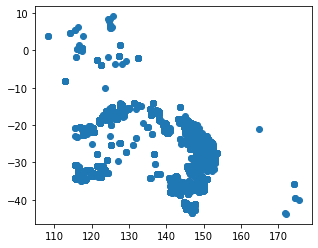

In [126]:
dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & (dea_s3_nearest_hotspot_gdf['sensor'] == 'MODIS')].plot()

## AVHRR vs S3

In [127]:
len(dea_s3_nearest_hotspot_gdf[#(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) & \
    
                               (dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & \
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'AVHRR')])

560

In [134]:
len(dea_s3_nearest_hotspot_gdf[#(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) & \
    
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'AVHRR')])

30738

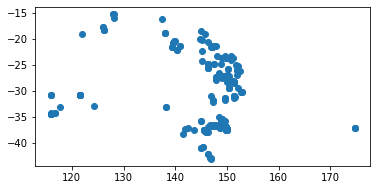

In [129]:
dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['dist'] < 0.005) & (dea_s3_nearest_hotspot_gdf['sensor'] == 'AVHRR')].plot()

In [130]:
len(dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) & \
                               (dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & \
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'VIIRS')])

982

In [131]:
len(dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['confidence'] > 85) & \
                               (dea_s3_nearest_hotspot_gdf['2_confidence'] > 0.90) & \
                               #(dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & \
                               (dea_s3_nearest_hotspot_gdf['sensor'] == 'VIIRS')])

1521

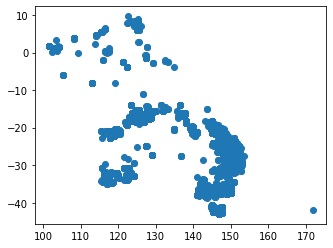

In [109]:
dea_s3_nearest_hotspot_gdf[(dea_s3_nearest_hotspot_gdf['dist'] < 0.05) & (dea_s3_nearest_hotspot_gdf['sensor'] == 'VIIRS')].plot()

In [135]:
dea_s3_nearest_hotspot_gdf.to_csv('dea_s3_nearest_hotspot_gdf.csv')

In [86]:
#TODO - group temporally - same solar day
#TODO - find nearest
# https://stackoverflow.com/questions/18737942/clustering-in-pythonscipy-with-space-and-time-variables

'''

You'll need to define your own metric, which handles "time" in an appropriate way. In the docs for scipy.spatial.distance.pdist you can define your own function

Y = pdist(X, f)

    Computes the distance between all pairs of vectors in X using the user supplied 2-arity function f. [...] For example, Euclidean distance between the vectors could be computed as follows:

dm = pdist(X, lambda u, v: np.sqrt(((u-v)**2).sum()))

The metric can be passed to any scipy clustering algorithm, via the metric keyword. For example, using linkage:

scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean')

'''

'\n\nYou\'ll need to define your own metric, which handles "time" in an appropriate way. In the docs for scipy.spatial.distance.pdist you can define your own function\n\nY = pdist(X, f)\n\n    Computes the distance between all pairs of vectors in X using the user supplied 2-arity function f. [...] For example, Euclidean distance between the vectors could be computed as follows:\n\ndm = pdist(X, lambda u, v: np.sqrt(((u-v)**2).sum()))\n\nThe metric can be passed to any scipy clustering algorithm, via the metric keyword. For example, using linkage:\n\nscipy.cluster.hierarchy.linkage(y, method=\'single\', metric=\'euclidean\')\n\n'

In [ ]:
hotspots_gdf.datetime